In [3]:
import pandas as pd
from pathlib import Path
download_path = Path.cwd()/".."/"data"/"UrbanSound8K"
metadata_file = download_path/'metadata'/'UrbanSound8K.csv'
df = pd.read_csv(metadata_file)
print(df.head())
print()
print("dataset value counts:")
print(df["class"].value_counts())

      slice_file_name    fsID  start        end  salience  fold  classID   
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3  \
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  

dataset value counts:
class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


In [4]:
df["relative_path"] = "fold" + df["fold"].astype(str) + "/" + df["slice_file_name"].astype(str)
formatted_df = df[["relative_path", "classID"]]
formatted_df.head()

,relative_path,classID
0,fold5/100032-3-0-0.wav,3
1,fold5/100263-2-0-117.wav,2
2,fold5/100263-2-0-121.wav,2
3,fold5/100263-2-0-126.wav,2
4,fold5/100263-2-0-137.wav,2


In [10]:
import numpy as np
import librosa

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        raise e
        return None
    return mfccsscaled

In [7]:
from tqdm import tqdm

features = []
for index, row in tqdm(formatted_df.iterrows(), total=formatted_df.__len__()):
    file_name = Path(download_path.resolve()) / "audio" / row["relative_path"]
    classid = row["classID"] == 3 # set True(1) if dog bark else False(0)
    data = extract_features(file_name)
    features.append([data, classid])

featuresdf = pd.DataFrame(features, columns=['feature','class'])

print('Finished feature extraction from ', len(featuresdf), ' files')

 41%|███████████████▊                       | 3553/8732 [02:12<03:44, 23.05it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████████████████████████████████▏ | 8325/8732 [05:13<00:09, 41.70it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|███████████████████████████████████████| 8732/8732 [05:26<00:00, 26.76it/s]

Finished feature extraction from  8732  files


In [8]:
featuresdf.head()

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",True
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",False
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",False
3,"[-413.89984, 101.66373, -35.42945, 53.036358, ...",False
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",False


In [9]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
class_list = featuresdf['class']
yy = np.array(class_list.tolist())
print(yy)

[ True False False ... False False False]


In [10]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [13]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

def create_model():
    # Construct model 
    model = Sequential()

    model.add(Dense(256, input_shape=(40,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='rmsprop')
    return model

In [14]:
model = create_model()

In [15]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               10496     
                                                                 
 activation_3 (Activation)   (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

2023-04-29 18:00:14.034946: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Pre-training accuracy: 80.0229%


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='../out/weights_singlelabel_rmsprop.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
219/219 [==============================] - ETA: 0s - loss: 2.0089 - accuracy: 0.8537
Epoch 1: val_loss improved from inf to 0.39292, saving model to out/weights_singlelabel_rmsprop.hdf5
219/219 [==============================] - 4s 11ms/step - loss: 2.0089 - accuracy: 0.8537 - val_loss: 0.3929 - val_accuracy: 0.9262
Epoch 2/100
217/219 [============================>.] - ETA: 0s - loss: 0.7977 - accuracy: 0.8757
Epoch 2: val_loss improved from 0.39292 to 0.35605, saving model to out/weights_singlelabel_rmsprop.hdf5
219/219 [==============================] - 2s 9ms/step - loss: 0.7942 - accuracy: 0.8762 - val_loss: 0.3561 - val_accuracy: 0.9141
Epoch 3/100
219/219 [==============================] - ETA: 0s - loss: 0.4431 - accuracy: 0.8959
Epoch 3: val_loss improved from 0.35605 to 0.21858, saving model to out/weights_singlelabel_rmsprop.hdf5
219/219 [==============================] - 2s 9ms/step - loss: 0.4431 - accuracy: 0.8959 - val_loss: 0.2186 - val_accuracy: 0.9222
Epoc

Epoch 28/100
215/219 [============================>.] - ETA: 0s - loss: 0.1638 - accuracy: 0.9458
Epoch 28: val_loss improved from 0.15846 to 0.15723, saving model to out/weights_singlelabel_rmsprop.hdf5
219/219 [==============================] - 2s 9ms/step - loss: 0.1649 - accuracy: 0.9452 - val_loss: 0.1572 - val_accuracy: 0.9536
Epoch 29/100
215/219 [============================>.] - ETA: 0s - loss: 0.1621 - accuracy: 0.9487
Epoch 29: val_loss did not improve from 0.15723
219/219 [==============================] - 2s 9ms/step - loss: 0.1615 - accuracy: 0.9486 - val_loss: 0.2247 - val_accuracy: 0.9468
Epoch 30/100
214/219 [============================>.] - ETA: 0s - loss: 0.1642 - accuracy: 0.9476
Epoch 30: val_loss did not improve from 0.15723
219/219 [==============================] - 2s 9ms/step - loss: 0.1649 - accuracy: 0.9476 - val_loss: 0.1888 - val_accuracy: 0.9508
Epoch 31/100
218/219 [============================>.] - ETA: 0s - loss: 0.1611 - accuracy: 0.9495
Epoch 31: val

Epoch 87/100
218/219 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9679
Epoch 87: val_loss did not improve from 0.15526
219/219 [==============================] - 2s 9ms/step - loss: 0.0975 - accuracy: 0.9679 - val_loss: 0.3128 - val_accuracy: 0.9628
Epoch 88/100
216/219 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9660
Epoch 88: val_loss did not improve from 0.15526
219/219 [==============================] - 2s 9ms/step - loss: 0.1180 - accuracy: 0.9661 - val_loss: 0.2645 - val_accuracy: 0.9628
Epoch 89/100
217/219 [============================>.] - ETA: 0s - loss: 0.1169 - accuracy: 0.9660
Epoch 89: val_loss did not improve from 0.15526
219/219 [==============================] - 2s 9ms/step - loss: 0.1184 - accuracy: 0.9658 - val_loss: 0.2727 - val_accuracy: 0.9651
Epoch 90/100
217/219 [============================>.] - ETA: 0s - loss: 0.1126 - accuracy: 0.9664
Epoch 90: val_loss did not improve from 0.15526
219/219 [==============

In [17]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9624910950660706
Testing Accuracy:  0.9605036973953247


In [18]:
# save the trained model to file
model.save("../out/model_rmsprop.h5")

In [3]:
import librosa
import numpy as np

def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
    except Exception:
        print("Error encountered while parsing file: ", file_name)
        return None

    return np.array([mfccsscaled])

def print_prediction(file_name):
    prediction_feature = extract_feature(file_name)

    predicted_class = model.predict(prediction_feature)
    print("The predicted class is:", np.round(predicted_class).reshape(-1))

In [4]:
# Detect bark
filename = Path.cwd()/"../data/bark.wav"
print(filename)
print_prediction(filename)

/Users/oliver/Projects/record7_with_microphone01_reduced_noise.wav


NameError: name 'model' is not defined

In [1]:
# loading the model

from tensorflow.keras.models import load_model

new_model = load_model("../out/model.h5")
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [4]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the model.
with open('../out/model_light.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Oliver\AppData\Local\Temp\tmp6tam122d\assets


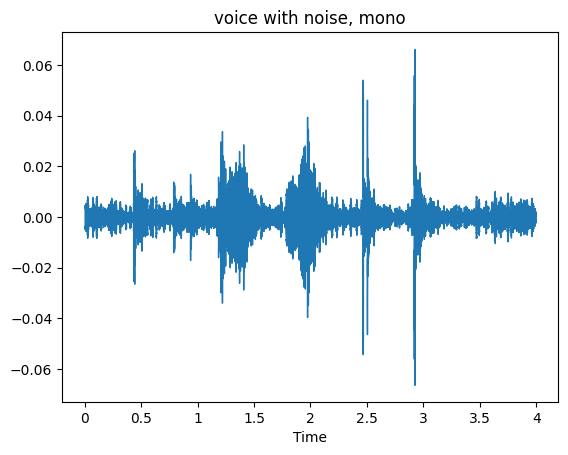

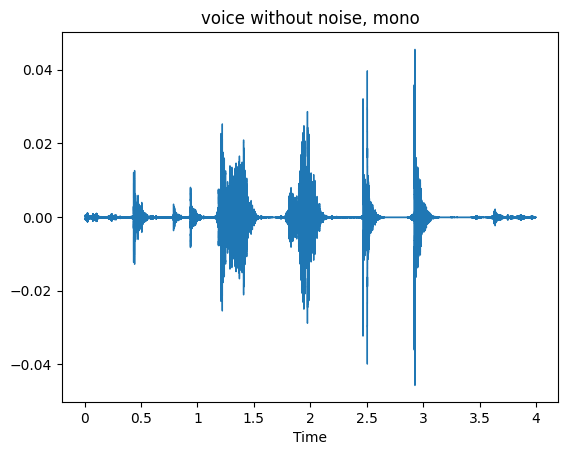

In [1]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
#import librosa.display
y, sr = librosa.load("/Users/oliver/Projects/record7_with_microphone01.wav", res_type='kaiser_fast')
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax)
ax.set(title='voice with noise, mono')
ax.label_outer()

y, sr = librosa.load("/Users/oliver/Projects/record7_with_microphone01_reduced_noise.wav", res_type='kaiser_fast')
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax)
ax.set(title='voice without noise, mono')
ax.label_outer()

#y, sr = librosa.load("out/record6_without_microphone01.wav", res_type='kaiser_fast')
#fig, ax = plt.subplots(nrows=1, sharex=True)
#librosa.display.waveshow(y, sr=sr, ax=ax)
#ax.set(title='without microphone, mono')
#ax.label_outer()

In [21]:
# reduce noise
from scipy.io import wavfile
import noisereduce as nr
# load data
rate, data = wavfile.read("/Users/oliver/Projects/record7_with_microphone01.wav")
# perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write("/Users/oliver/Projects/record7_with_microphone01_reduced_noise.wav", rate, reduced_noise)

In [4]:
print_prediction("/Users/oliver/Projects/record7_with_microphone01.wav")

1/1 [==============================] - 0s 109ms/step
The predicted class is: [0.]


2023-05-02 15:11:17.570081: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [48]:
import pandas as pd
metadata_file = Path.cwd()/".."/"data"/"ESC-50-master"/'meta'/'esc50.csv'
df_esc50 = pd.read_csv(metadata_file)
print(df_esc50.head())
print()
print("dataset value counts:")
print(df_esc50["category"].value_counts())

            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

dataset value counts:
category
dog                 40
glass_breaking      40
drinking_sipping    40
rain                40
insects             40
laughing            40
hen                 40
engine              40
breathing           40
crying_baby         40
hand_saw            40
coughing            40
snoring             40
chirping_birds      40
toilet_flush        40
pig                 40
washing_machine     40
clock_tick          40
sneezing            40
rooster             40
sea_waves           40
siren               40
cat                 40
d

In [51]:
df_esc50['absolute_path'] = Path.cwd()/'..'/'data'/'ESC-50-master'/'audio'/df_esc50['filename']
df_esc50_formatted = df_esc50[['absolute_path', 'category']].copy()
df_esc50_formatted['is_dog'] = df_esc50_formatted['category'] == "dog" # set to True if audio is dog bark else False
del df_esc50_formatted['category'] # delete not needed string category
df_esc50_formatted.head()

,absolute_path,is_dog
0,/Users/oliver/Projects/DogBarkingDetection/mod...,True
1,/Users/oliver/Projects/DogBarkingDetection/mod...,False
2,/Users/oliver/Projects/DogBarkingDetection/mod...,False
3,/Users/oliver/Projects/DogBarkingDetection/mod...,False
4,/Users/oliver/Projects/DogBarkingDetection/mod...,False


In [53]:
featuresdf.head()

,feature,class
0,"[-601.2905, 5.188324, -8.995635, -3.794092, -1...",True
1,"[-199.9886, 11.223685, -67.78312, 12.683219, -...",False
2,"[8.070245, 68.47494, -20.432165, 26.459608, -2...",False
3,"[9.428114, 66.635605, -18.865862, 25.202358, -...",False
4,"[-427.5323, 131.2091, 32.553005, 41.130276, -8...",False


In [52]:
from tqdm import tqdm

features = []
for index, row in tqdm(df_esc50_formatted.iterrows(), total=df_esc50_formatted.__len__()):
    file_name = row["absolute_path"]
    classid = row["is_dog"]
    data = extract_features(file_name)
    features.append([data, classid])

featuresdf = pd.DataFrame(features, columns=['feature','class'])

print('Finished feature extraction from ', len(featuresdf), ' files')

100%|███████████████████████████████████████| 2000/2000 [01:21<00:00, 24.46it/s]

Finished feature extraction from  2000  files


In [55]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
class_list = featuresdf['class']
yy = np.array(class_list.tolist())
print(yy)
X

[ True False False ... False False  True]


array([[-6.01290527e+02,  5.18832397e+00, -8.99563503e+00, ...,
        -1.11813873e-01, -3.37912776e-02,  3.96593735e-02],
       [-1.99988602e+02,  1.12236853e+01, -6.77831192e+01, ...,
         2.57396483e+00,  1.69794440e+00, -7.87848353e-01],
       [ 8.07024479e+00,  6.84749374e+01, -2.04321651e+01, ...,
         1.51724470e+00, -4.01145124e+00,  7.34217167e+00],
       ...,
       [-2.90242401e+02,  8.61444397e+01,  6.49497318e+00, ...,
        -1.30036068e+00, -1.38159677e-01, -1.14594412e+00],
       [-1.54213318e+02,  1.03575005e+02, -4.62283516e+01, ...,
         2.15180323e-01,  4.70789790e-01,  2.05195260e+00],
       [-4.92227997e+02,  6.96694279e+00, -3.17226334e+01, ...,
        -3.58440131e-01,  1.55207646e+00,  1.24741447e+00]], dtype=float32)

In [56]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [60]:
# loading the model

from tensorflow.keras.models import load_model

model = load_model("../out/model.h5")
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               10496     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
50/50 [==============================] - 1s 8ms/step - loss: 0.2675 - accuracy: 0.9569 - val_loss: 0.0828 - val_accuracy: 0.9825
Epoch 2/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0957 - accuracy: 0.9806 - val_loss: 0.0899 - val_accuracy: 0.9850
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0758 - accuracy: 0.9794 - val_loss: 0.0795 - val_accuracy: 0.9825
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0668 - accuracy: 0.9844 - val_loss: 0.0788 - val_accuracy: 0.9800
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0744 - accuracy: 0.9787 - val_loss: 0.0526 - val_accuracy: 0.9825
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0689 - accuracy: 0.9844 - val_loss: 0.0543 - val_accuracy: 0.9850
Epoch 7/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0530 - accuracy: 0.9831 - val_loss: 0.0637 - val_accuracy: 0.9850
Epoch 8/100
5

Epoch 59/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0190 - accuracy: 0.9931 - val_loss: 0.0944 - val_accuracy: 0.9875
Epoch 60/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0152 - accuracy: 0.9956 - val_loss: 0.0866 - val_accuracy: 0.9875
Epoch 61/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0150 - accuracy: 0.9925 - val_loss: 0.0897 - val_accuracy: 0.9800
Epoch 62/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0158 - accuracy: 0.9931 - val_loss: 0.0971 - val_accuracy: 0.9875
Epoch 63/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0236 - accuracy: 0.9925 - val_loss: 0.1198 - val_accuracy: 0.9875
Epoch 64/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0262 - accuracy: 0.9925 - val_loss: 0.1149 - val_accuracy: 0.9850
Epoch 65/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0146 - accuracy: 0.9950 - val_loss: 0.1094 - val_accuracy: 0.9825
Epoch 

In [62]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9975000023841858
Testing Accuracy:  0.9799999594688416


In [63]:
# save the trained model to file
model.save("../out/model_with_esc50.h5")